In [120]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import warnings
from secret import path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import skfuzzy as fuzz
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
from scipy.stats import shapiro
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings("ignore")

In [121]:
# Loading our dataset in pandas libraries for analysis and data manipulation if needed
main_df = pd.read_csv(path+"\\creditcard.csv")
main_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [122]:
value_counts = main_df['Class'].value_counts()
# Access the counts for 0 and 1
count_0 = value_counts.get(0, 0)  # Get count of 0, default to 0 if not found
count_1 = value_counts.get(1, 0)  # Get count of 1, default to 0 if not found

print(f"Count of 0s: {count_0}")
print(f"Count of 1s: {count_1}")

Count of 0s: 284315
Count of 1s: 492


## **With such severe class imbalance we will have to balance the target class**
To do that we will be using **Combining Oversampling and Undersampling**:<br>
A hybrid approach that involves both oversampling the minority class and undersampling the majority class can sometimes be effective. This combination aims to balance the class distribution while retaining important data from both classes.

**Models we will be using for class balancing**<br>
Combining oversampling and undersampling techniques can help mitigate class imbalance effectively. The idea is to oversample the minority class and undersample the majority class. One common method for doing this is to apply **SMOTE** to oversample the minority class and **Tomek links** to undersample the majority class.

In [123]:
# Split the dataset into features (X) and the target (y)
X = main_df.drop('Class', axis=1)
y = main_df['Class']

In [124]:
# Splitting the data into trainig and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Applying SMOTE and Tomek Link
smt = SMOTETomek(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

In [125]:
value_counts = y_resampled.value_counts()
# Access the counts for 0 and 1
count_0 = value_counts.get(0, 0)  # Get count of 0, default to 0 if not found
count_1 = value_counts.get(1, 0)  # Get count of 1, default to 0 if not found

print(f"Count of 0s: {count_0}")
print(f"Count of 1s: {count_1}")

Count of 0s: 189878
Count of 1s: 189878


In [126]:
new_X = X_resampled.drop(columns=['Time', 'Amount'])
new_y = y_resampled

In [127]:
new_df = pd.concat([new_X, new_y], axis=1)

In [128]:
new_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.146174,-0.083967,0.602963,0.725410,-0.396283,0.186275,-0.318544,0.185287,0.362387,-0.085385,...,-0.155253,-0.012052,0.219314,-0.068172,0.077802,0.482796,0.451360,-0.002776,-0.003524,0
1,-0.918050,0.578744,1.168159,-0.862173,0.969264,0.483973,0.953430,0.188512,-0.866718,-0.734780,...,0.104206,0.102956,0.073220,-0.324398,-1.129387,0.622502,0.395548,-0.042526,0.032731,0
2,-2.013096,-3.261460,-1.443935,0.149307,2.734412,-1.572646,0.380914,-0.058952,0.668700,-1.065447,...,1.377841,0.398680,0.005726,1.652294,0.136111,-1.705085,-0.522617,-0.031407,0.243772,0
3,-0.767334,0.383415,0.210914,0.035407,0.059217,1.220341,-0.053366,0.718190,-1.945750,0.732852,...,-0.064315,-0.145465,-0.121835,-0.023886,-1.764699,-0.060345,-0.080600,0.292808,0.112469,0
4,-0.817828,1.621705,0.911472,1.305673,-0.402086,1.031816,-1.972642,-5.092458,-1.570995,-1.018347,...,1.300047,-2.932584,-0.519522,0.194226,0.138621,0.768231,-0.580148,0.027377,0.213998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379751,0.679700,1.540100,-3.973319,3.246800,-1.318832,-1.247697,-2.690558,0.945387,-0.860826,-3.528455,...,0.222976,0.702632,0.808361,0.249517,-0.083311,-0.624011,-0.125647,0.512995,0.118961,1
379752,-3.066417,3.103746,-6.007741,6.115009,-3.421706,-2.245275,-7.047451,2.241073,-4.059386,-8.106495,...,0.724847,1.402739,0.335055,-0.440825,0.276359,-0.248180,0.091298,1.490299,0.362991,1
379753,-5.332616,4.158638,-8.559197,8.291702,-5.729850,-3.061968,-10.986349,3.413224,-6.158060,-11.481715,...,1.151241,2.322009,0.832277,-0.594645,0.519497,-0.693671,0.331819,2.231584,0.493555,1
379754,-4.263903,5.634666,-6.869213,6.416934,-2.159099,-0.856003,-7.296221,-2.957433,-4.322919,-8.244381,...,1.824317,-0.949120,1.340380,-0.008937,-0.393551,0.212535,0.168180,0.298572,0.169891,1


In [129]:
# Concise summary of data, including information about missing values and data types
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379756 entries, 0 to 379755
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      379756 non-null  float64
 1   V2      379756 non-null  float64
 2   V3      379756 non-null  float64
 3   V4      379756 non-null  float64
 4   V5      379756 non-null  float64
 5   V6      379756 non-null  float64
 6   V7      379756 non-null  float64
 7   V8      379756 non-null  float64
 8   V9      379756 non-null  float64
 9   V10     379756 non-null  float64
 10  V11     379756 non-null  float64
 11  V12     379756 non-null  float64
 12  V13     379756 non-null  float64
 13  V14     379756 non-null  float64
 14  V15     379756 non-null  float64
 15  V16     379756 non-null  float64
 16  V17     379756 non-null  float64
 17  V18     379756 non-null  float64
 18  V19     379756 non-null  float64
 19  V20     379756 non-null  float64
 20  V21     379756 non-null  float64
 21  V22     37

In [130]:
# Basic statistics for each numeric column, such as mean, min, max, etc
new_df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,...,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000
mean,-2.200265,1.757693,-3.439202,2.318355,-1.455467,-0.743176,-2.651231,0.467233,-1.287373,-2.780981,...,0.165783,0.318771,0.014259,-0.049150,-0.056204,0.026099,0.048025,0.098248,0.039955,0.500000
std,5.013107,3.320793,5.790576,3.108122,3.845931,1.611285,5.181273,3.811937,2.159098,4.210190,...,0.927889,1.973545,0.924262,0.964289,0.538511,0.619208,0.449111,0.900156,0.403250,0.500001
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,-24.588262,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,0.000000
25%,-2.827974,-0.095068,-5.207258,-0.062661,-1.747905,-1.529695,-3.152308,-0.184902,-2.292297,-4.542348,...,-0.190609,-0.151305,-0.500178,-0.229720,-0.388084,-0.299653,-0.256343,-0.063915,-0.058258,0.000000
50%,-0.765140,1.011116,-1.524533,1.494238,-0.415271,-0.701114,-0.754119,0.172513,-0.793219,-1.031135,...,0.035765,0.168190,0.018283,-0.033461,-0.005785,0.050646,0.022322,0.060911,0.035848,0.500000
75%,0.851278,2.876505,0.274741,4.489177,0.443977,-0.010115,0.183228,0.848806,0.091680,-0.033860,...,0.421627,0.639640,0.511562,0.176604,0.336114,0.372856,0.328695,0.438077,0.201878,1.000000
max,2.454930,22.057729,4.187811,16.875344,34.801666,73.301626,120.589494,20.007208,10.348407,15.245686,...,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000


In [131]:
# Calculating the percentage of null/Nan values in our dataset.
(new_df[new_df.columns].isnull().sum()/new_df.shape[0])*100

V1       0.0
V2       0.0
V3       0.0
V4       0.0
V5       0.0
V6       0.0
V7       0.0
V8       0.0
V9       0.0
V10      0.0
V11      0.0
V12      0.0
V13      0.0
V14      0.0
V15      0.0
V16      0.0
V17      0.0
V18      0.0
V19      0.0
V20      0.0
V21      0.0
V22      0.0
V23      0.0
V24      0.0
V25      0.0
V26      0.0
V27      0.0
V28      0.0
Class    0.0
dtype: float64

# **Shapiro-Wilk Test**
- The Shapiro-Wilk test is a statistical test that checks if a dataset follows a normal distribution. A low p-value (typically less than 0.05) indicates that the data significantly deviates from a normal distribution.

In [132]:
# Performing the Shapiro-Wilk test for each column in main_df
for column in new_df.columns:
    stat, p = shapiro(new_df[column])
    print(f'{column}: Statistics={stat}, p={p}')

V1: Statistics=0.7069604396820068, p=0.0
V2: Statistics=0.8459051251411438, p=0.0
V3: Statistics=0.7683205604553223, p=0.0
V4: Statistics=0.9536792039871216, p=0.0
V5: Statistics=0.7399948239326477, p=0.0
V6: Statistics=0.9486317038536072, p=0.0
V7: Statistics=0.6992595195770264, p=0.0
V8: Statistics=0.5835127234458923, p=0.0
V9: Statistics=0.9311937689781189, p=0.0
V10: Statistics=0.833716630935669, p=0.0
V11: Statistics=0.9252386689186096, p=0.0
V12: Statistics=0.8450649976730347, p=0.0
V13: Statistics=0.9987892508506775, p=1.4566838780858506e-36
V14: Statistics=0.8777220249176025, p=0.0
V15: Statistics=0.9890421628952026, p=0.0
V16: Statistics=0.8347029685974121, p=0.0
V17: Statistics=0.7863301634788513, p=0.0
V18: Statistics=0.8606085181236267, p=0.0
V19: Statistics=0.9806700348854065, p=0.0
V20: Statistics=0.7257179021835327, p=0.0
V21: Statistics=0.5168805718421936, p=0.0
V22: Statistics=0.8532589077949524, p=0.0
V23: Statistics=0.507538914680481, p=0.0
V24: Statistics=0.98505878

# **Histograms**
- Visualize the distribution of each feature using histograms. Normally distributed data should resemble a bell curve.

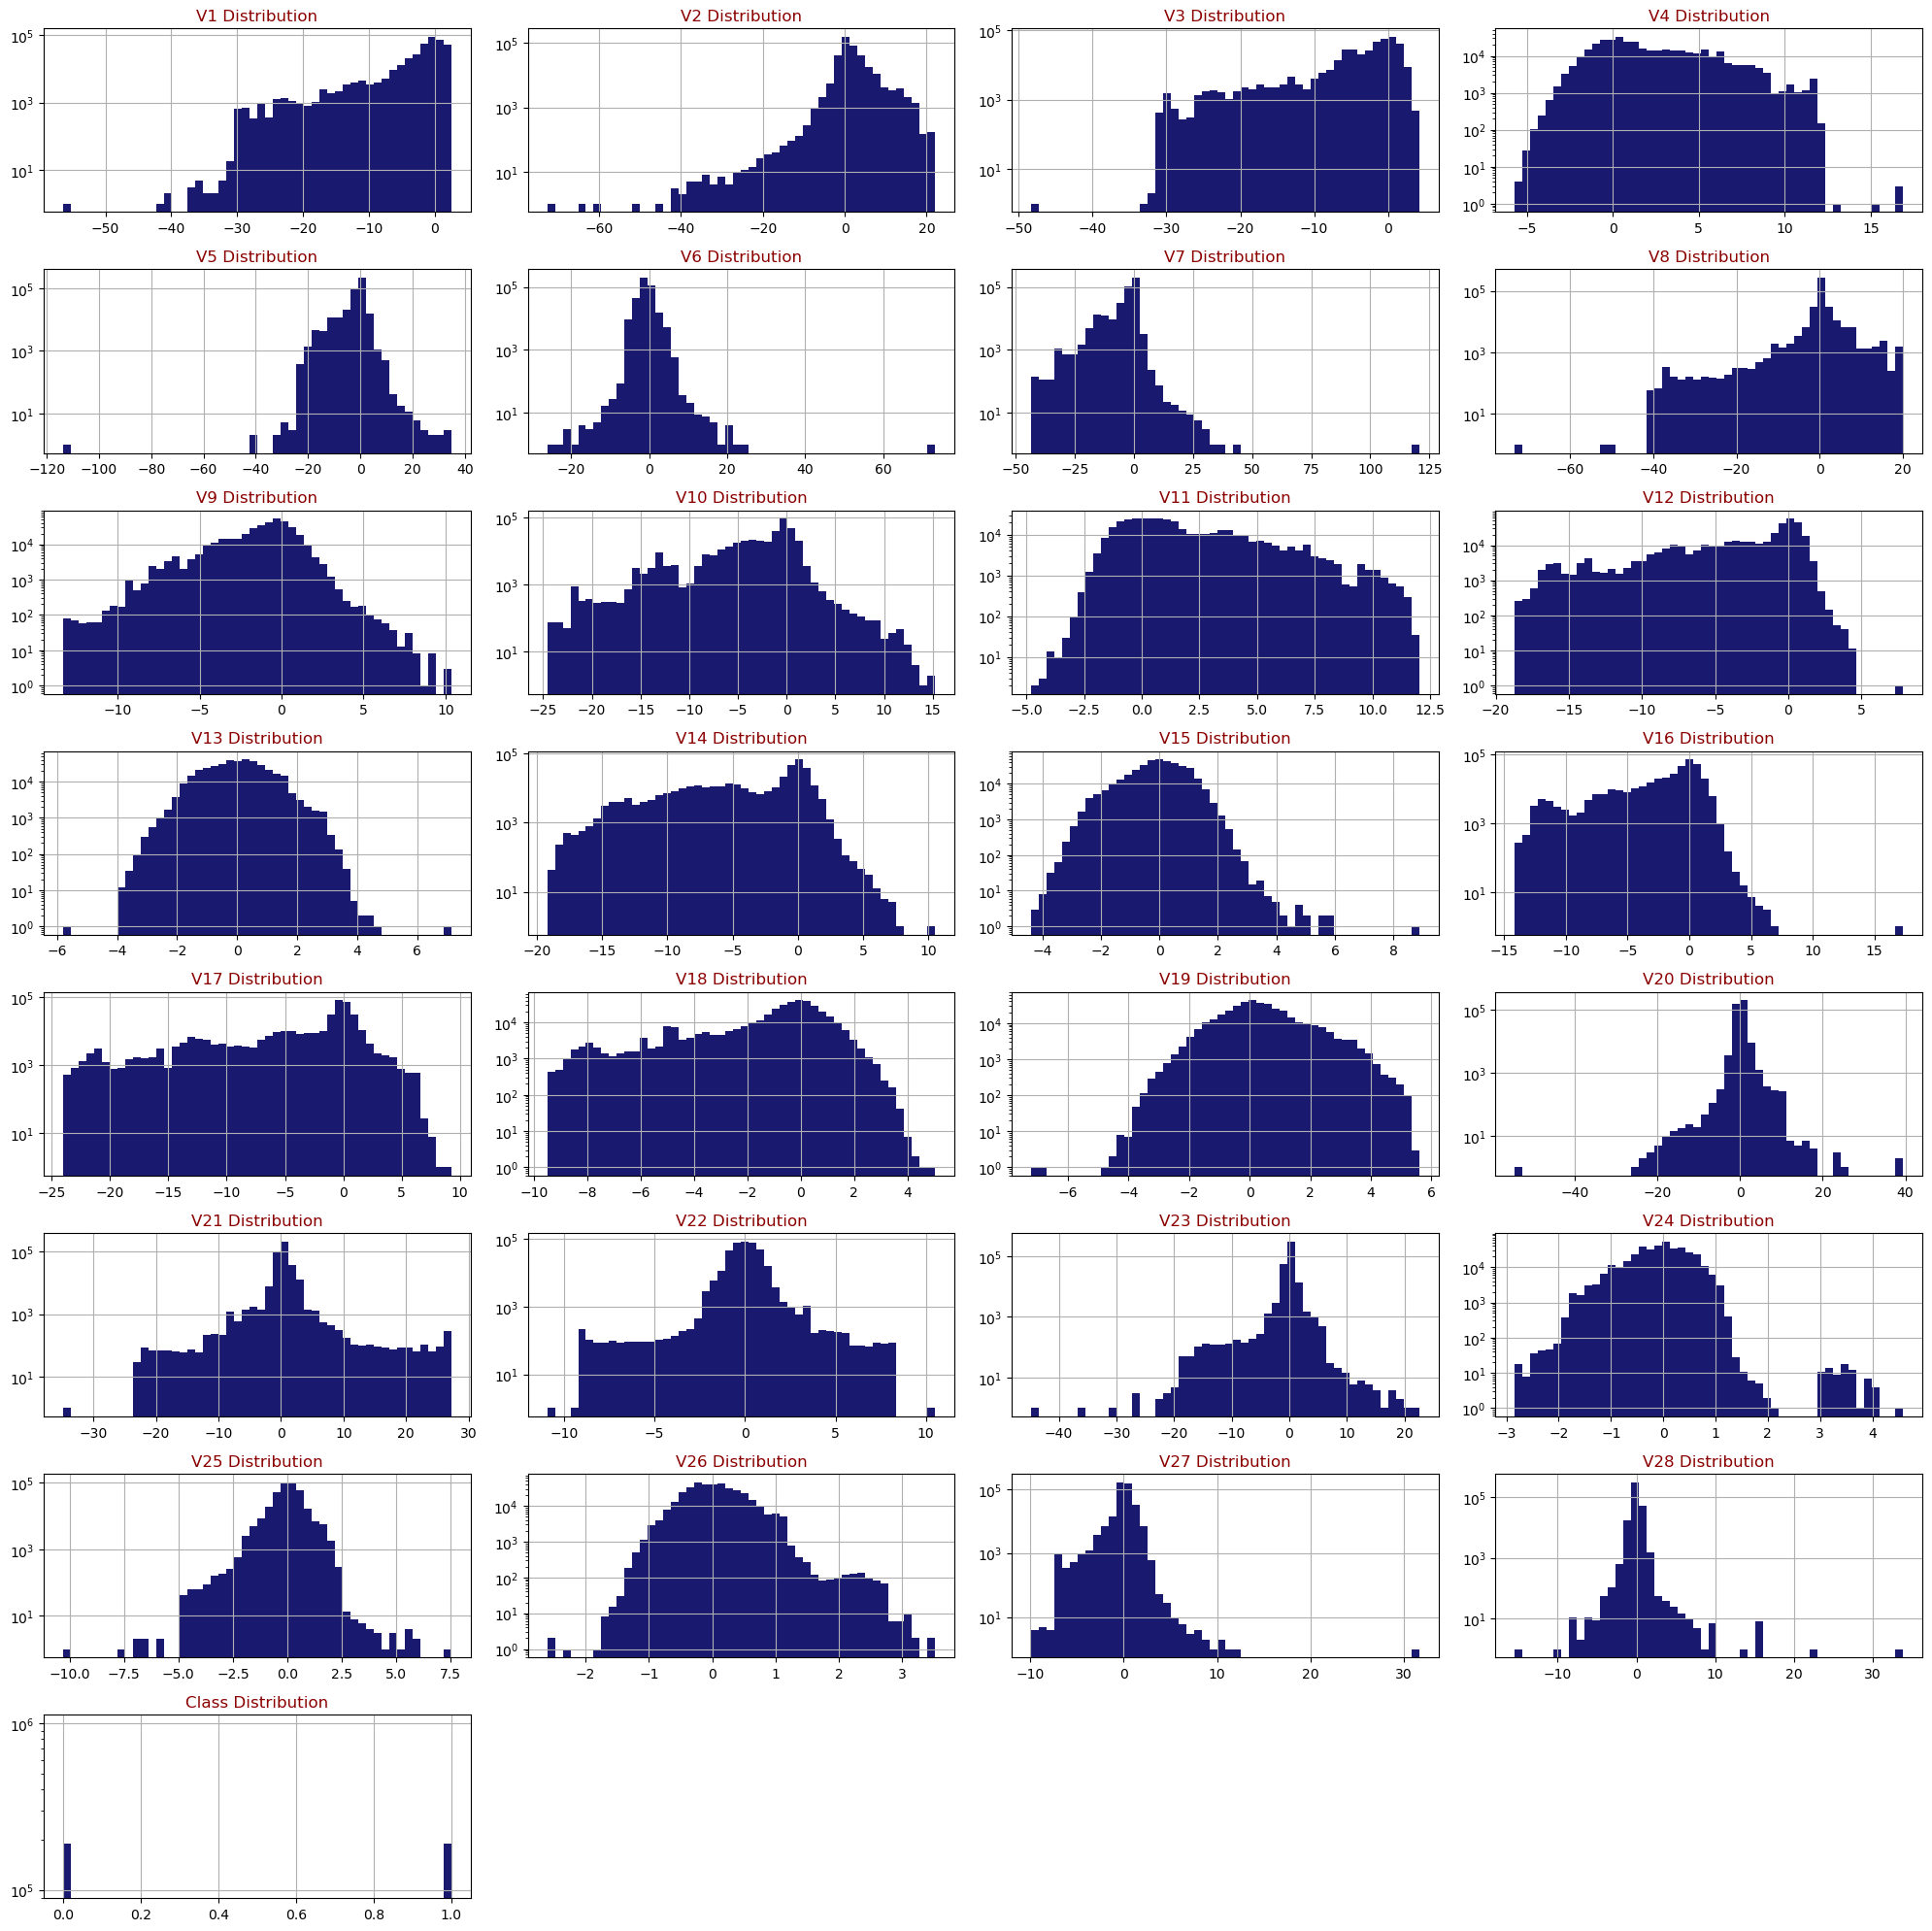

In [133]:
def draw_histograms(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, features in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        df[features].hist(bins = 50 , ax = ax, facecolor='midnightblue')
        ax.set_title(features+" Distribution", color="DarkRed")
        ax.set_yscale('log')
    fig.tight_layout()
    plt.show()  
    
draw_histograms(new_df, new_df.columns, 8, 4)

# **Q-Q Plots**
- Quantile-quantile (Q-Q) plots compare the quantiles of your data to the quantiles of a theoretical normal distribution. Normally distributed data should roughly follow a diagonal line.

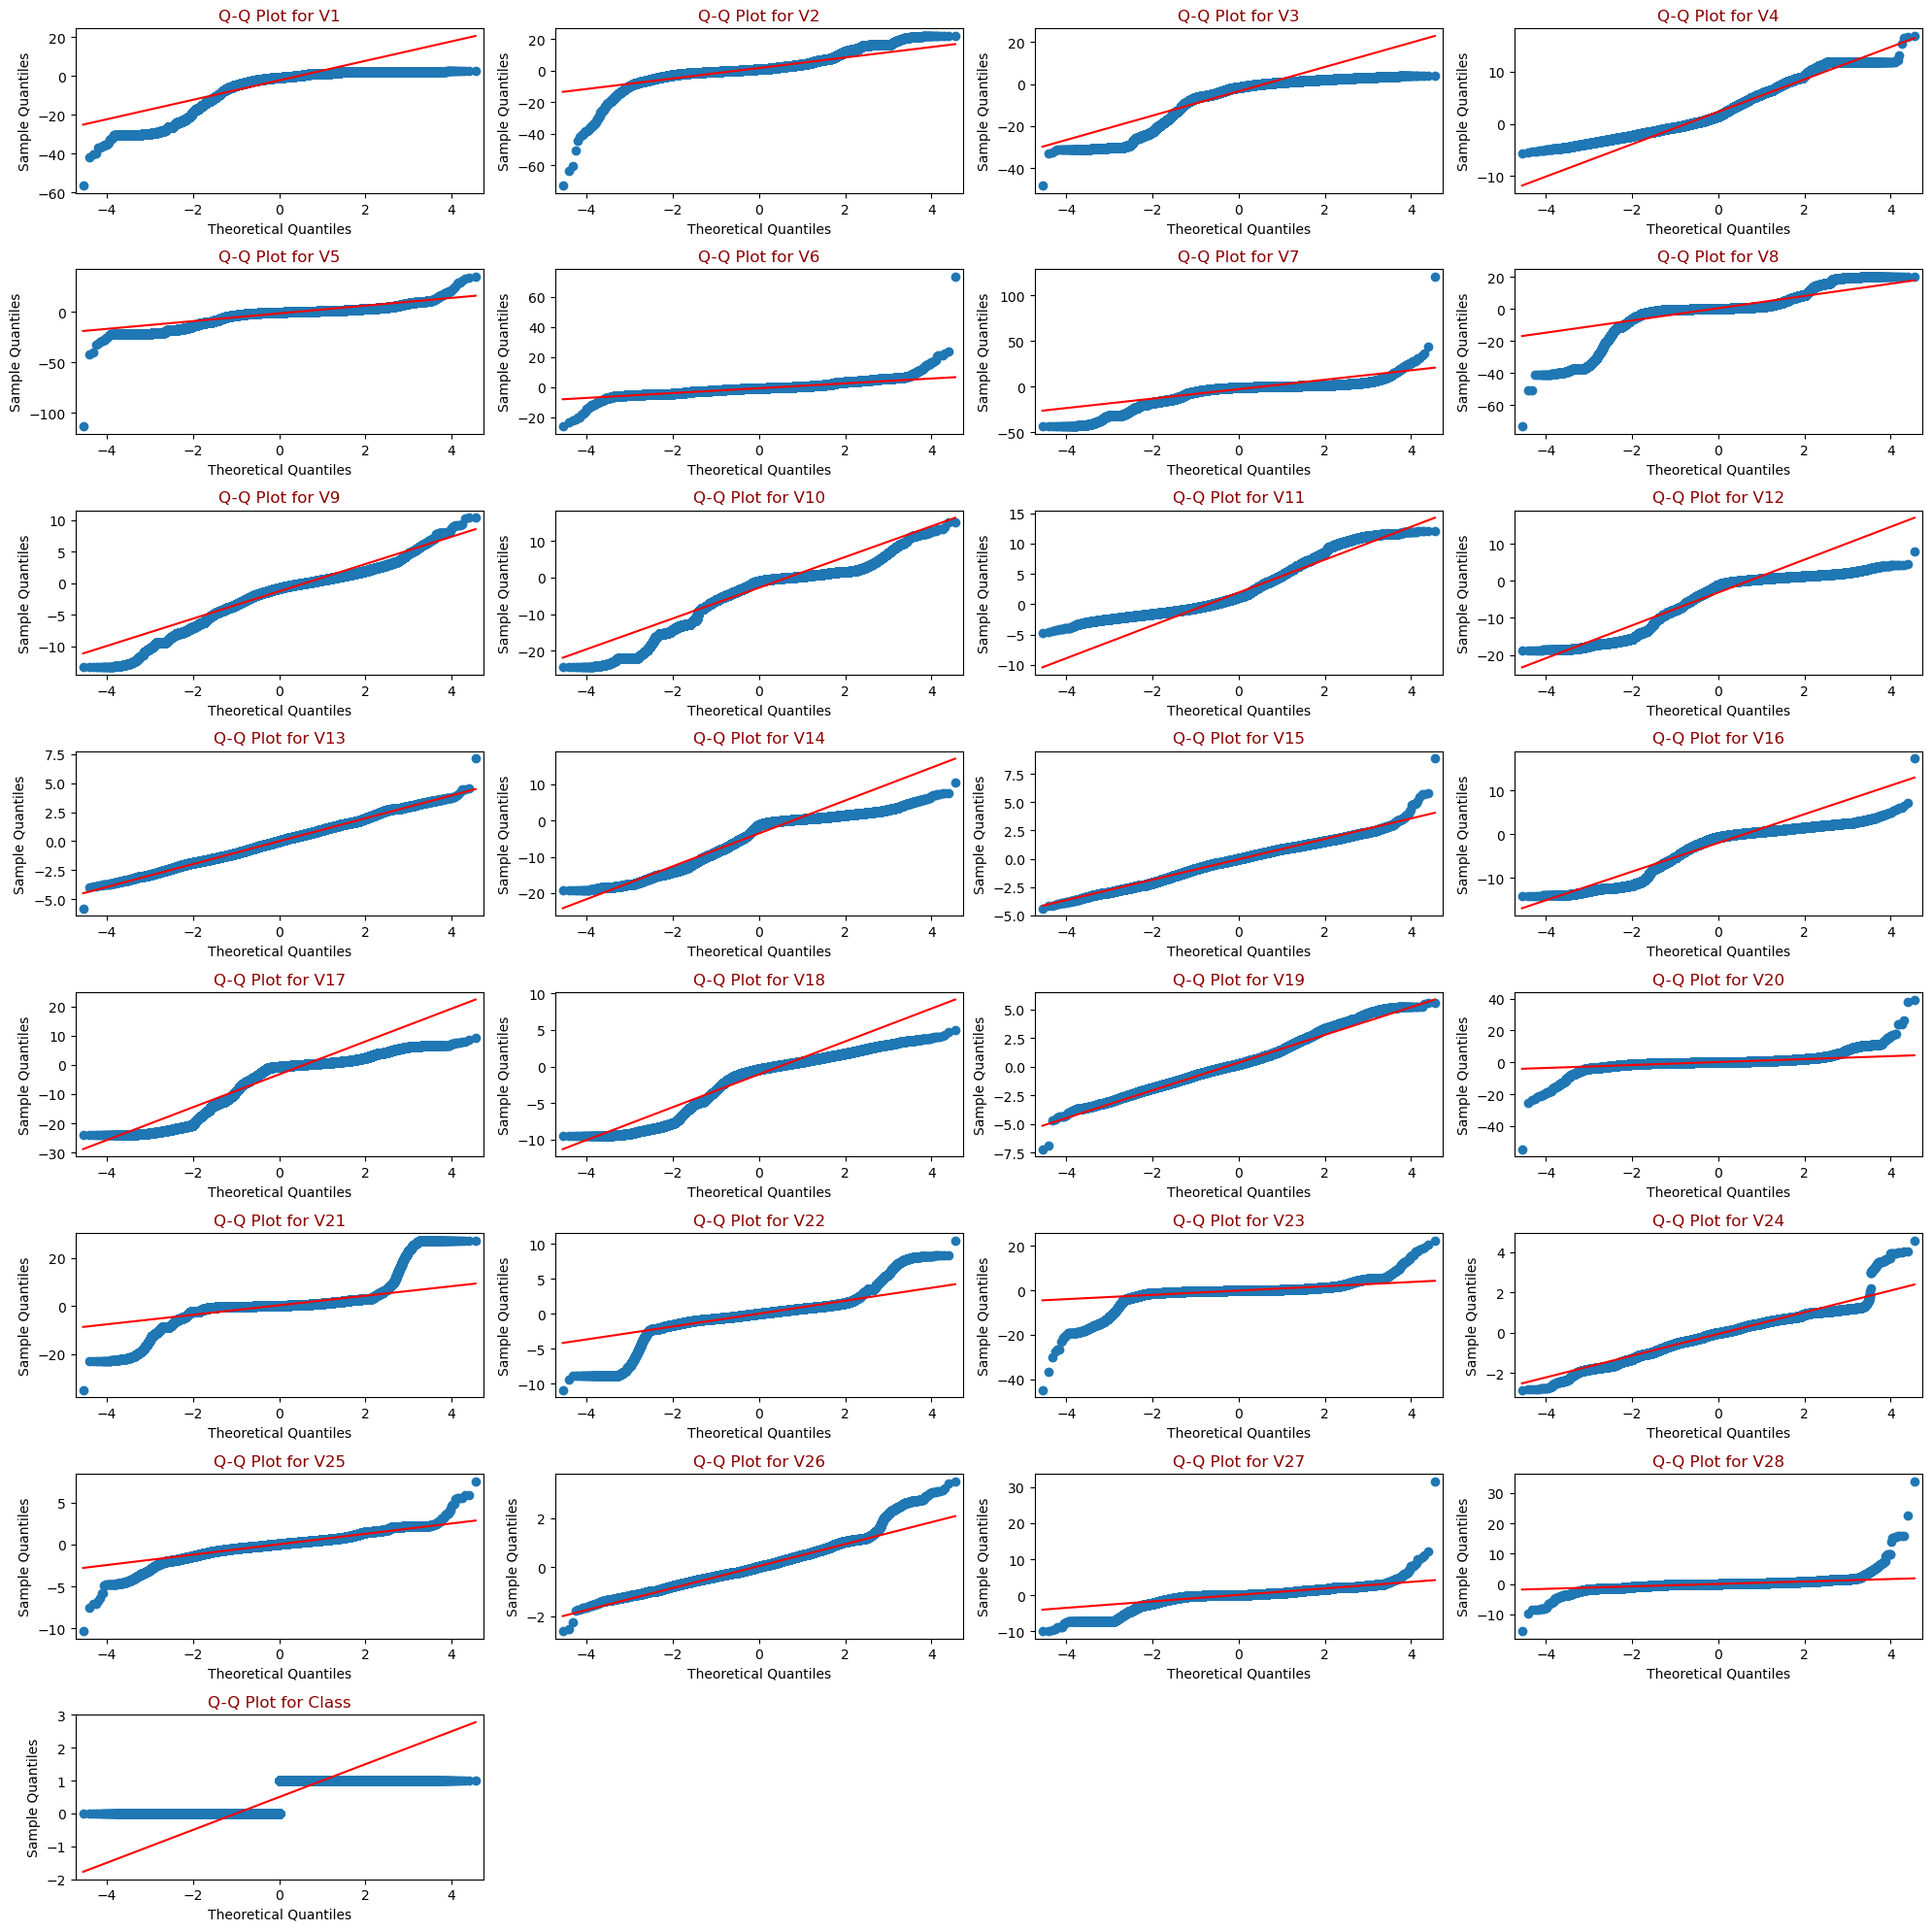

In [134]:
def draw_qq_plots(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        sm.qqplot(df[feature], line='s', ax=ax)
        ax.set_title(f'Q-Q Plot for {feature}', color='DarkRed')
    fig.tight_layout()
    plt.show()

draw_qq_plots(new_df, new_df.columns, 8, 4)


# **Data Normalization for Machine Learning**
From our above statistical analysis we can see our data is not normalized so we are going to normalize our data.

In [135]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your dataset
normalized_data = scaler.fit_transform(new_df.drop(columns=['Class']))

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(data=normalized_data, columns=new_df.columns[:-1])

# Create a DataFrame for the target variable
target_df = pd.DataFrame(data=new_df['Class'], columns=['Class'])

# Concatenate the features and target variable DataFrames
normalized_df = pd.concat([normalized_df, target_df], axis=1)

# Check the first few rows of the normalized DataFrame
normalized_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.667539,-0.554585,0.698060,-0.512511,0.275404,0.576839,0.450216,-0.073964,0.764098,0.640256,...,-0.345986,-0.167629,0.221859,-0.019727,0.248846,0.737551,0.898075,-0.112229,-0.107821,0
1,0.255773,-0.355021,0.795666,-1.023297,0.630467,0.761597,0.695710,-0.073118,0.194829,0.486012,...,-0.066363,-0.109354,0.063792,-0.285442,-1.992875,0.963172,0.773802,-0.156388,-0.017913,0
2,0.037336,-1.511434,0.344572,-0.697865,1.089433,-0.514788,0.585213,-0.138036,0.905969,0.407472,...,1.306254,0.040490,-0.009232,1.764456,0.357125,-2.795806,-1.270604,-0.144036,0.505437,0
3,0.285837,-0.413841,0.630355,-0.734511,0.393841,1.218605,0.501396,0.065835,-0.304932,0.834603,...,-0.247981,-0.235230,-0.147246,0.026199,-3.172636,-0.139605,-0.286400,0.216141,0.179826,0
4,0.275765,-0.040950,0.751338,-0.325818,0.273895,1.101601,0.130970,-1.458497,-0.131362,0.418659,...,1.222415,-1.647471,-0.577522,0.252389,0.361785,1.198520,-1.398704,-0.078732,0.431601,0


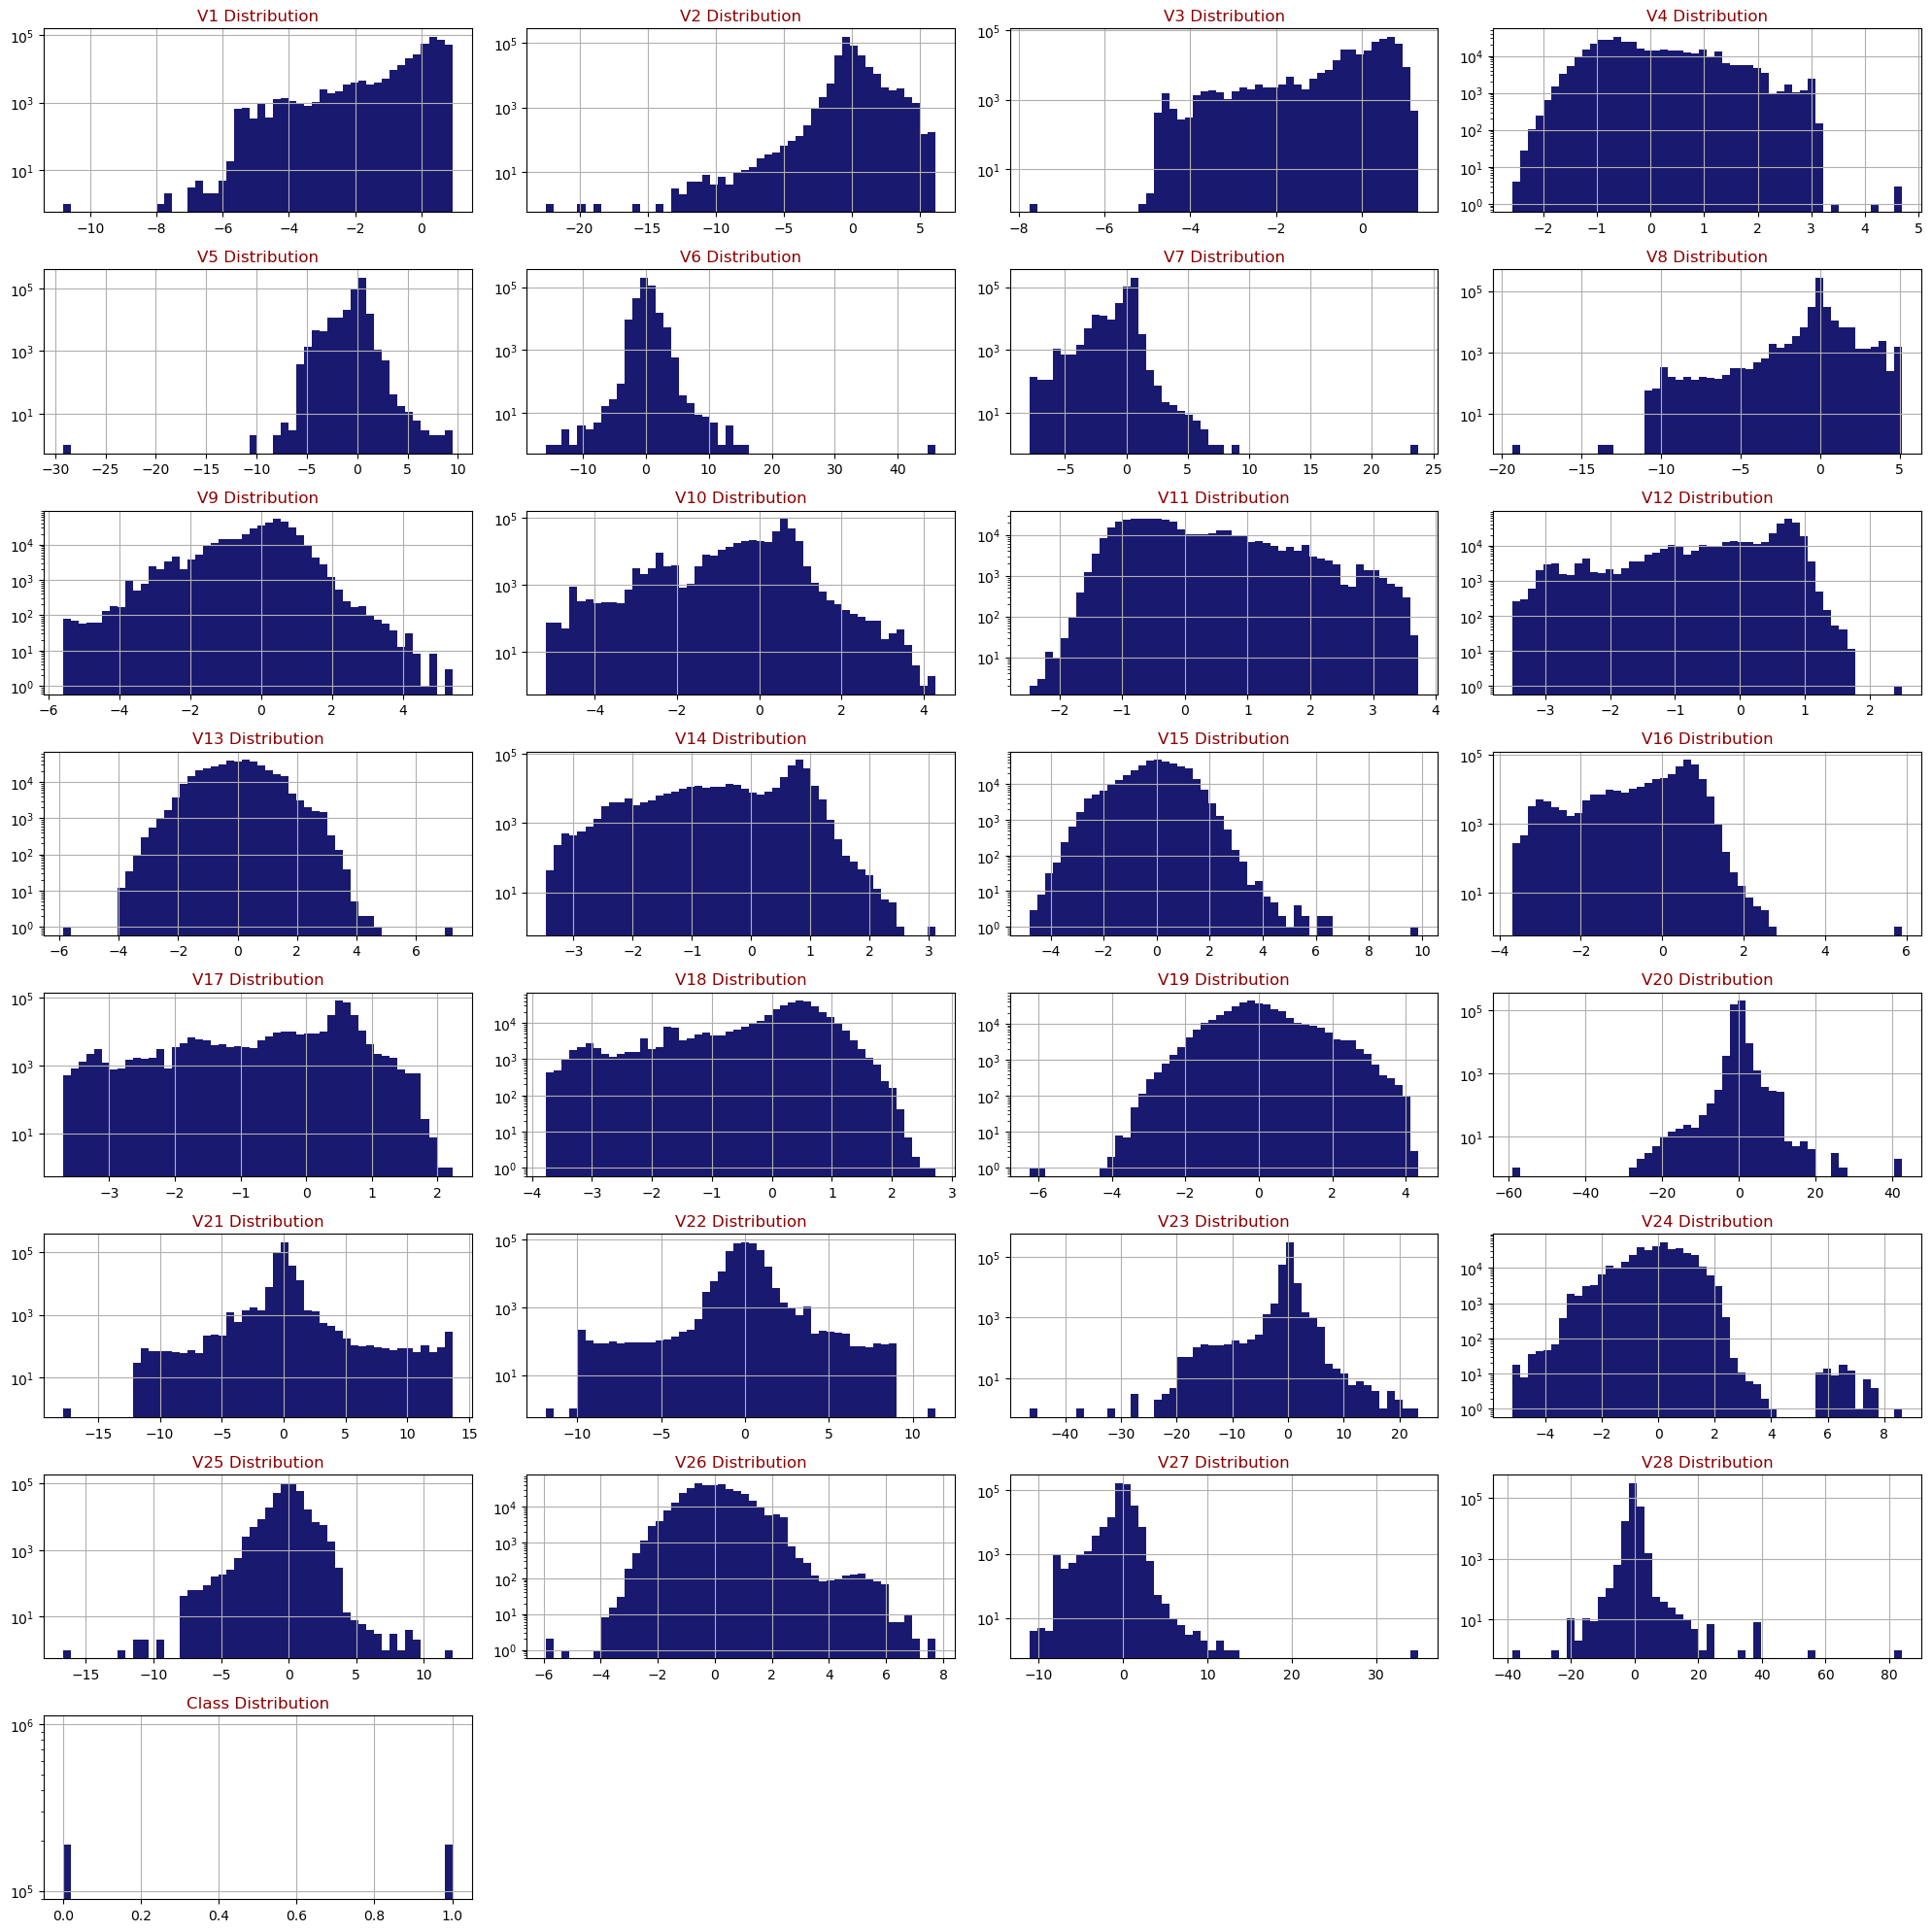

In [136]:
def draw_histograms(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, features in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        df[features].hist(bins = 50 , ax = ax, facecolor='midnightblue')
        ax.set_title(features+" Distribution", color="DarkRed")
        ax.set_yscale('log')
    fig.tight_layout()
    plt.show()  
    
draw_histograms(normalized_df, normalized_df.columns, 8, 4)

In [137]:
# Performing the Shapiro-Wilk test for each column in main_df
for column in normalized_df.columns:
    stat, p = shapiro(normalized_df[column])
    print(f'{column}: Statistics={stat}, p={p}')

V1: Statistics=0.7069606781005859, p=0.0
V2: Statistics=0.8459049463272095, p=0.0
V3: Statistics=0.7683206796646118, p=0.0
V4: Statistics=0.9536790251731873, p=0.0
V5: Statistics=0.739995002746582, p=0.0
V6: Statistics=0.9486318826675415, p=0.0
V7: Statistics=0.6992595195770264, p=0.0
V8: Statistics=0.583512544631958, p=0.0
V9: Statistics=0.9311938881874084, p=0.0
V10: Statistics=0.8337163925170898, p=0.0
V11: Statistics=0.9252384901046753, p=0.0
V12: Statistics=0.8450646996498108, p=0.0
V13: Statistics=0.9987892508506775, p=1.4566838780858506e-36
V14: Statistics=0.8777218461036682, p=0.0
V15: Statistics=0.9890421628952026, p=0.0
V16: Statistics=0.8347032070159912, p=0.0
V17: Statistics=0.7863300442695618, p=0.0
V18: Statistics=0.8606083989143372, p=0.0
V19: Statistics=0.9806703925132751, p=0.0
V20: Statistics=0.7257179617881775, p=0.0
V21: Statistics=0.5168806314468384, p=0.0
V22: Statistics=0.8532589673995972, p=0.0
V23: Statistics=0.507538914680481, p=0.0
V24: Statistics=0.985058963

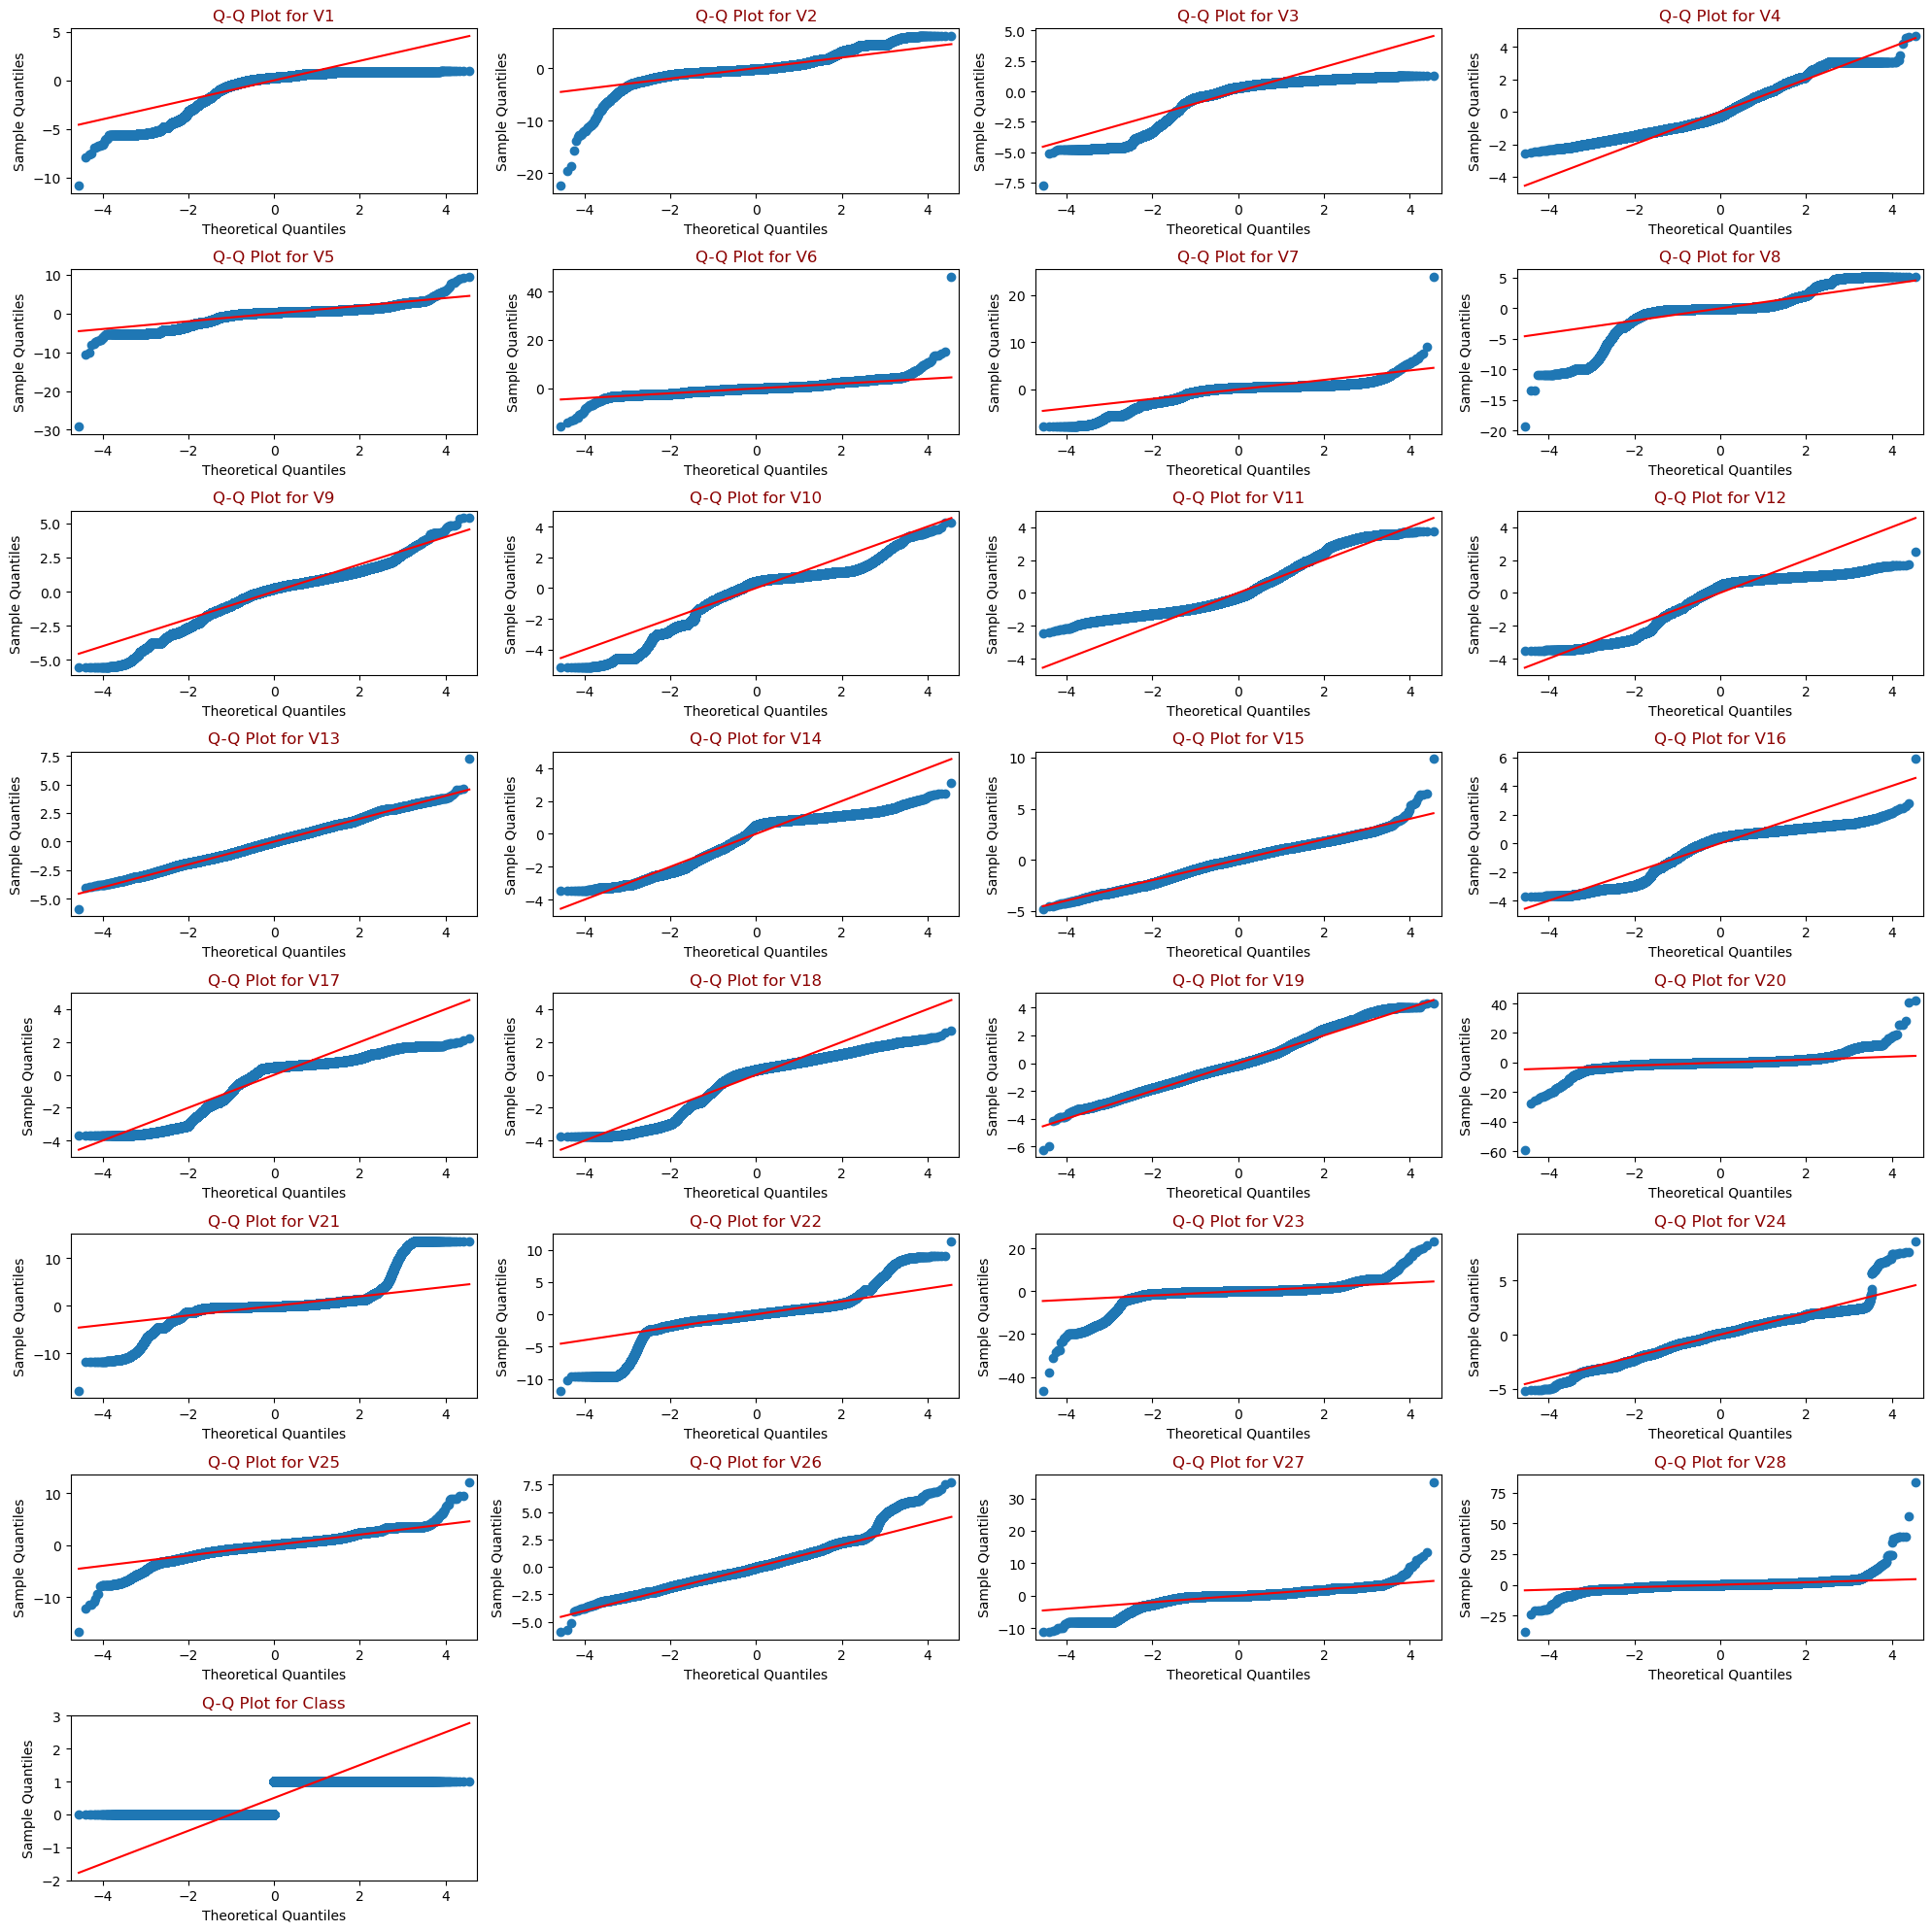

In [138]:
def draw_qq_plots(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        sm.qqplot(df[feature], line='s', ax=ax)
        ax.set_title(f'Q-Q Plot for {feature}', color='DarkRed')
    fig.tight_layout()
    plt.show()

draw_qq_plots(normalized_df, normalized_df.columns, 8, 4)

In [139]:
normalized_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.667539,-0.554585,0.698060,-0.512511,0.275404,0.576839,0.450216,-0.073964,0.764098,0.640256,...,-0.345986,-0.167629,0.221859,-0.019727,0.248846,0.737551,0.898075,-0.112229,-0.107821,0
1,0.255773,-0.355021,0.795666,-1.023297,0.630467,0.761597,0.695710,-0.073118,0.194829,0.486012,...,-0.066363,-0.109354,0.063792,-0.285442,-1.992875,0.963172,0.773802,-0.156388,-0.017913,0
2,0.037336,-1.511434,0.344572,-0.697865,1.089433,-0.514788,0.585213,-0.138036,0.905969,0.407472,...,1.306254,0.040490,-0.009232,1.764456,0.357125,-2.795806,-1.270604,-0.144036,0.505437,0
3,0.285837,-0.413841,0.630355,-0.734511,0.393841,1.218605,0.501396,0.065835,-0.304932,0.834603,...,-0.247981,-0.235230,-0.147246,0.026199,-3.172636,-0.139605,-0.286400,0.216141,0.179826,0
4,0.275765,-0.040950,0.751338,-0.325818,0.273895,1.101601,0.130970,-1.458497,-0.131362,0.418659,...,1.222415,-1.647471,-0.577522,0.252389,0.361785,1.198520,-1.398704,-0.078732,0.431601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379751,0.574488,-0.065524,-0.092239,0.298716,0.035527,-0.313118,-0.007590,0.125436,0.197558,-0.177540,...,0.061638,0.194503,0.859176,0.309728,-0.050338,-1.049907,-0.386702,0.460751,0.195923,1
379752,-0.172778,0.405342,-0.443573,1.221528,-0.511253,-0.932238,-0.848484,0.465339,-1.283877,-1.264912,...,0.602512,0.549250,0.347085,-0.406181,0.617562,-0.442952,0.096353,1.546458,0.801082,1
379753,-0.624833,0.723005,-0.884196,1.921853,-1.111406,-1.439097,-1.608703,0.772834,-2.255892,-2.066592,...,1.062044,1.015047,0.885051,-0.565697,1.069064,-1.162405,0.631901,2.369965,1.124863,1
379754,-0.411649,1.167486,-0.592345,1.318669,-0.182955,-0.070023,-0.896497,-0.898407,-1.405934,-1.297663,...,1.787429,-0.642444,1.434791,0.041702,-0.626445,0.301088,0.267539,0.222544,0.322224,1


In [140]:
value_counts = normalized_df["Class"].value_counts()
# Access the counts for 0 and 1
count_0 = value_counts.get(0, 0)  # Get count of 0, default to 0 if not found
count_1 = value_counts.get(1, 0)  # Get count of 1, default to 0 if not found

print(f"Count of 0s: {count_0}")
print(f"Count of 1s: {count_1}")

Count of 0s: 189878
Count of 1s: 189878


In [141]:
# Assignment of training set...
X_train, y_train = X_resampled.drop(columns=['Time', 'Amount']), y_resampled

# # Using the normalized data for training and testing
# X_train_norm, X_test_norm = scaler.transform(X_train), scaler.transform(X_test)

# Defining the number of features to select (N)
N = 10

In [142]:
# Using the normalized data for training and testing
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test.drop(columns=['Time', 'Amount'])), columns=X_test.columns[1:29])

In [143]:
# Method 1: Mutual Information for feature selection
mi_selector = SelectKBest(mutual_info_classif, k=N)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
X_test_mi = mi_selector.transform(X_test)

In [144]:
# Method 2: SelectKBest (e.g., chi-squared) for feature selection
skb_selector = SelectKBest(k=N)
X_train_skb = skb_selector.fit_transform(X_train, y_train)
X_test_skb = skb_selector.transform(X_test)

In [145]:
# Method 3: Random Forest Classifier (RFC) for feature selection
# Fit a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Sort feature indices by importance
selected_feature_indices = np.argsort(feature_importances)[::-1]
selected_feature_indices = selected_feature_indices[selected_feature_indices < X_train.shape[1]]


In [146]:
# Select the top N feature
top_N_features = X_train.columns[selected_feature_indices[:10]]

In [147]:
# Selecting the feature from datasets
# Extract the selected features from your dataset
X_train_rfc = X_train[top_N_features]
X_test_rfc = X_test[top_N_features]

In [148]:
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid for n_neighbors
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Initializing KNeighborsClassifier
knn = KNeighborsClassifier()

# Initializing GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fiting the grid search to the data
grid_search.fit(X_train, y_train)

# Geting the best parameters
best_params = grid_search.best_params_
best_n_neighbors = best_params['n_neighbors']

# Printing the best parameters
print(f"Best Number of Neighbors: {best_n_neighbors}")

# Using the best n_neighbors for your KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)

Best Number of Neighbors: 3


In [149]:
# Training and evaluating a K-Nearest Neighbors (KNN) classifier using full dataset...
# Evaluating Full dataset
print("Fitting KNN with Full Dataset...")
knn.fit(X_train, y_train)
print("Predicting with Full Dataset...")
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
clr = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:\n", clr)
print("\n\n")

Fitting KNN with Full Dataset...
Predicting with Full Dataset...
Accuracy: 0.9987551469884133
Precision: 0.5740740740740741
Recall: 0.8322147651006712
F1 Score: 0.6794520547945205
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.57      0.83      0.68       149

    accuracy                           1.00     93987
   macro avg       0.79      0.92      0.84     93987
weighted avg       1.00      1.00      1.00     93987






In [150]:
# Evaluating Mutual Information selected features
print("Fitting KNN with Mutual Information selected features...")
knn.fit(X_train_mi, y_train)
print("Predicting with Mutual Information selected features...")
y_pred_mi = knn.predict(X_test_mi)
accuracy_mi = accuracy_score(y_test, y_pred_mi)
precision_mi = precision_score(y_test, y_pred_mi)
recall_mi = recall_score(y_test, y_pred_mi)
f1_mi = f1_score(y_test, y_pred_mi)
clr_mi = classification_report(y_test, y_pred_mi)
print("Accuracy:", accuracy_mi)
print("Precision:", precision_mi)
print("Recall:", recall_mi)
print("F1 Score:", f1_mi)
print("Classification Report:\n", clr_mi)
print("\n\n")

Fitting KNN with Mutual Information selected features...
Predicting with Mutual Information selected features...
Accuracy: 0.9983295562152212
Precision: 0.48507462686567165
Recall: 0.87248322147651
F1 Score: 0.6235011990407674
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.49      0.87      0.62       149

    accuracy                           1.00     93987
   macro avg       0.74      0.94      0.81     93987
weighted avg       1.00      1.00      1.00     93987






In [151]:
# Evaluating SelectKBest selected features
print("Fitting with SelectKBest selected features...")
knn.fit(X_train_skb, y_train)
print("Predicting with SelectKBest selected features...")
y_pred_skb = knn.predict(X_test_skb)
accuracy_skb = accuracy_score(y_test, y_pred_skb)
precision_skb = precision_score(y_test, y_pred_skb)
recall_skb = recall_score(y_test, y_pred_skb)
f1_skb = f1_score(y_test, y_pred_skb)
clr_skb = classification_report(y_test, y_pred_skb)
print("Accuracy:", accuracy_skb)
print("Precision:", precision_skb)
print("Recall:", recall_skb)
print("F1 Score:", f1_skb)
print("Classification Report:\n", clr_skb)
print("\n\n")


Fitting with SelectKBest selected features...
Predicting with SelectKBest selected features...
Accuracy: 0.9983295562152212
Precision: 0.4852941176470588
Recall: 0.8859060402684564
F1 Score: 0.6270783847980997
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.49      0.89      0.63       149

    accuracy                           1.00     93987
   macro avg       0.74      0.94      0.81     93987
weighted avg       1.00      1.00      1.00     93987






In [152]:
# Evaluating RFC selected features
print("Fitting with Random Forest Classifier selected features...")
knn.fit(X_train_rfc, y_train)
print("Predicting with Random Forest Classifier selected features...")
y_pred_rfc = knn.predict(X_test_rfc)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
precision_rfc = precision_score(y_test, y_pred_rfc)
recall_rfc = recall_score(y_test, y_pred_rfc)
f1_rfc = f1_score(y_test, y_pred_rfc)
clr_rfc = classification_report(y_test, y_pred_rfc)
print("Accuracy:", accuracy_rfc)
print("Precision:", precision_rfc)
print("Recall:", recall_rfc)
print("F1 Score:", f1_rfc)
print("Classification Report:\n", clr_rfc)

Fitting with Random Forest Classifier selected features...
Predicting with Random Forest Classifier selected features...
Accuracy: 0.9983295562152212
Precision: 0.48507462686567165
Recall: 0.87248322147651
F1 Score: 0.6235011990407674
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.49      0.87      0.62       149

    accuracy                           1.00     93987
   macro avg       0.74      0.94      0.81     93987
weighted avg       1.00      1.00      1.00     93987



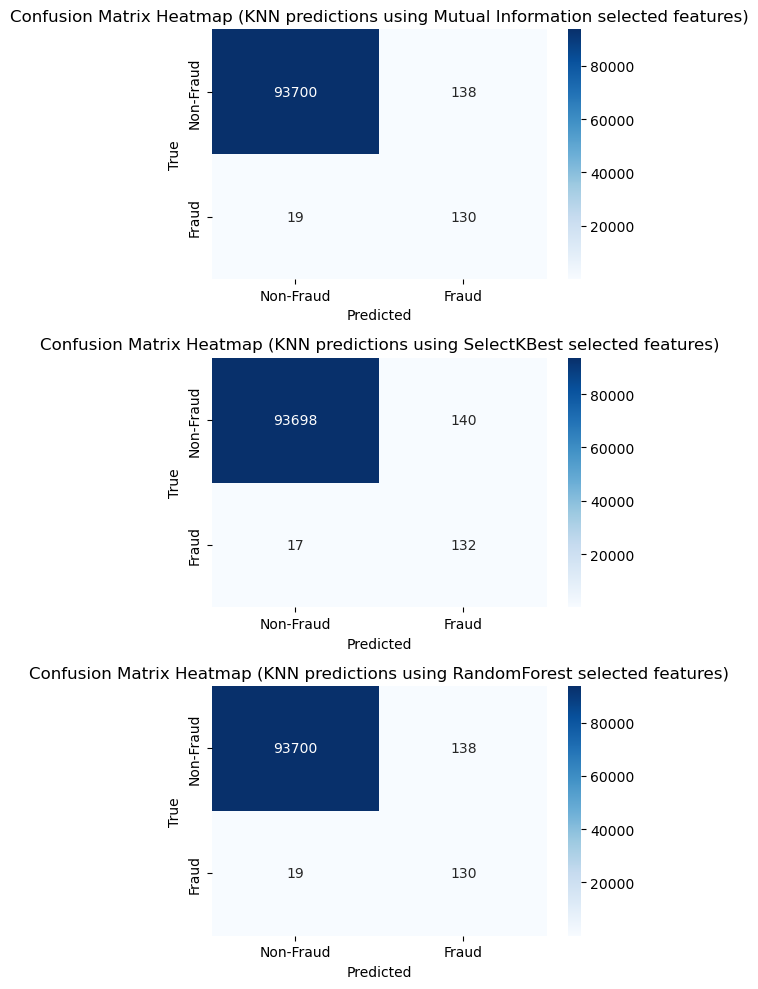

In [153]:
# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(3, 1, figsize=(5, 10))

# Computing confusion matrices for KNN and Random Forest
cm_mi = confusion_matrix(y_test, y_pred_mi)
cm_skb = confusion_matrix(y_test, y_pred_skb)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

# Ploting the confusion matrix for KNN predictions using Mutual Information selected features on the first subplot
sns.heatmap(cm_mi, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix Heatmap (KNN predictions using Mutual Information selected features)')

# Ploting the confusion matrix for KNN predictions using SelectKBest selected features on the second subplot
sns.heatmap(cm_skb, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix Heatmap (KNN predictions using SelectKBest selected features)')

# Ploting the confusion matrix for KNN predictions using RandomForest selected features on the second subplot
sns.heatmap(cm_rfc, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_title('Confusion Matrix Heatmap (KNN predictions using RandomForest selected features)')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

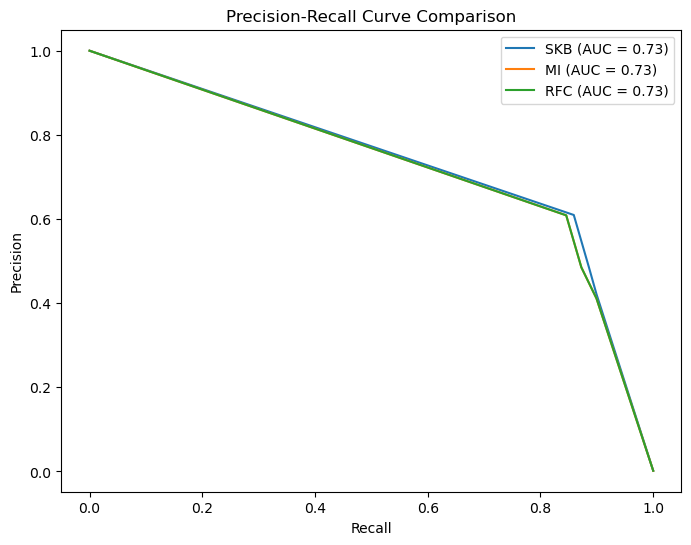

In [154]:
# Create KNN models with selected features
knn_skb = KNeighborsClassifier(n_neighbors=3).fit(X_train_skb, y_train)
knn_mi = KNeighborsClassifier(n_neighbors=3).fit(X_train_mi, y_train)
knn_rfc = KNeighborsClassifier(n_neighbors=3).fit(X_train_rfc, y_train)

# Compute precision-recall curves
y_scores_skb = knn_skb.predict_proba(skb_selector.transform(X_test))[:, 1]
precision_skb, recall_skb, _ = precision_recall_curve(y_test, y_scores_skb)

y_scores_mi = knn_mi.predict_proba(mi_selector.transform(X_test))[:, 1]
precision_mi, recall_mi, _ = precision_recall_curve(y_test, y_scores_mi)

y_scores_rfc = knn_rfc.predict_proba(X_test_rfc)[:, 1]
precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_scores_rfc)

# Compute area under the curve (AUC)
auc_score_skb = auc(recall_skb, precision_skb)
auc_score_mi = auc(recall_mi, precision_mi)
auc_score_rfc = auc(recall_rfc, precision_rfc)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_skb, precision_skb, label=f'SKB (AUC = {auc_score_skb:.2f})')
plt.plot(recall_mi, precision_mi, label=f'MI (AUC = {auc_score_mi:.2f})')
plt.plot(recall_rfc, precision_rfc, label=f'RFC (AUC = {auc_score_rfc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.show()

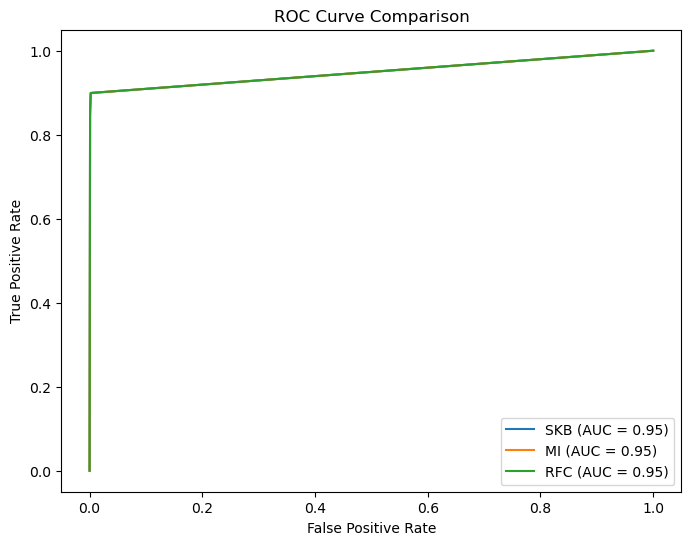

In [155]:
# Computing ROC curves
y_scores_skb = knn_skb.predict_proba(skb_selector.transform(X_test))[:, 1]
fpr_skb, tpr_skb, _ = roc_curve(y_test, y_scores_skb)

y_scores_mi = knn_mi.predict_proba(mi_selector.transform(X_test))[:, 1]
fpr_mi, tpr_mi, _ = roc_curve(y_test, y_scores_mi)

y_scores_rfc = knn_rfc.predict_proba(X_test_rfc)[:, 1]
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_scores_rfc)

# Compute AUC (Area Under the Curve)
auc_score_skb = roc_auc_score(y_test, y_scores_skb)
auc_score_mi = roc_auc_score(y_test, y_scores_mi)
auc_score_rfc = roc_auc_score(y_test, y_scores_rfc)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_skb, tpr_skb, label=f'SKB (AUC = {auc_score_skb:.2f})')
plt.plot(fpr_mi, tpr_mi, label=f'MI (AUC = {auc_score_mi:.2f})')
plt.plot(fpr_rfc, tpr_rfc, label=f'RFC (AUC = {auc_score_rfc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()

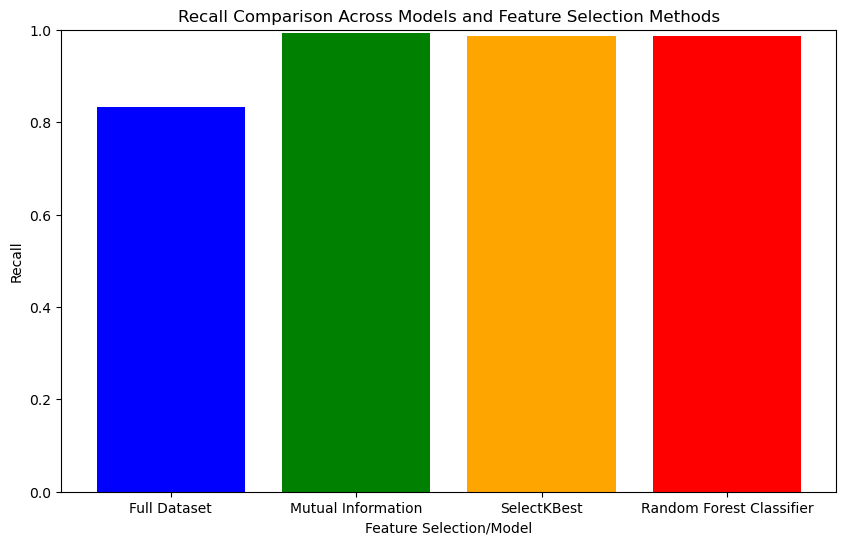

In [156]:
# List of recall values for each scenario
recall_values = [recall, 0.9932885906040269, 0.9865771812080537, 0.9865771812080537]

# List of labels for each scenario
labels = ['Full Dataset', 'Mutual Information', 'SelectKBest', 'Random Forest Classifier']

# Convert recall_values to a list (ensure it's a list of numerical values)
recall_values = list(recall_values)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, recall_values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Feature Selection/Model')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Models and Feature Selection Methods')
plt.ylim(0, 1)  # Set y-axis limit to ensure consistent scale
plt.show()

In [157]:
value_counts = y_test.value_counts()
# Access the counts for 0 and 1
count_0 = value_counts.get(0, 0)  # Get count of 0, default to 0 if not found
count_1 = value_counts.get(1, 0)  # Get count of 1, default to 0 if not found

print(f"Count of 0s: {count_0}")
print(f"Count of 1s: {count_1}")

Count of 0s: 93838
Count of 1s: 149


In [168]:
from skfuzzy.cluster import cmeans, cmeans_predict
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

X_train_normalized = scaler.fit_transform(X_train_mi)
X_test_normalized = scaler.fit_transform(X_test_mi)

best_score = -1  # Initialize a variable to track the best score

# Define a range of values to search for n_clusters and m
n_clusters_values = [3, 4, 5, 6]
m_values = [1.1, 1.2, 1.3, 1.4, 1.5]

# Maximum number of iterations
max_iterations = 100

# Tolerance for stopping criteria
tolerance = 1e-6

# Loop over n_clusters and m values to find the best parameters
for n_clusters in n_clusters_values:
    for m in m_values:
        # Train the FCM model with the current parameters
        cntr, u_train, u0_train, d_train, jm_train, p_train, fpc_train = cmeans(
            X_train_normalized.T, c=n_clusters, m=m, error=tolerance, maxiter=max_iterations
        )

        # Apply FCM model to the test data
        u_test, _, _, _, _, _ = cmeans_predict(
            X_test_normalized.T, cntr, m, tolerance, max_iterations
        )

        # Extract the predicted labels for the test set
        for threshold in np.unique(u_test.argmax(axis=0)):
            binary_labels_test_fcm = (u_test.argmax(axis=0) >= threshold).astype(int)
            # Evaluate performance using relevant metrics
            recall_fcm = recall_score(
                y_test, binary_labels_test_fcm, pos_label=1, average='binary'
            )
            precision_fcm = precision_score(
                y_test, binary_labels_test_fcm, pos_label=1, average='binary'
            )
            f1_fcm = f1_score(y_test, binary_labels_test_fcm, pos_label=1, average='binary')
            confusion_fcm = confusion_matrix(y_test, binary_labels_test_fcm)

            # Print or store the results for analysis
            print(f"FCM - n_clusters: {n_clusters}, m: {m}, Threshold: {threshold}")
            print(f"Recall: {recall_fcm:.4f}, Precision: {precision_fcm:.4f}, F1 Score: {f1_fcm:.4f}")
            print("Confusion Matrix:")
            print(confusion_fcm)
            print("=" * 30)

            # Check if the current parameters give a better score
            if recall_fcm > best_score:
                best_score = recall_fcm
                best_n_clusters = n_clusters
                best_m = m

print("Best FCM Parameters - n_clusters: {}, m: {}".format(best_n_clusters, best_m))

FCM - n_clusters: 3, m: 1.1, Threshold: 0
Recall: 1.0000, Precision: 0.0016, F1 Score: 0.0032
Confusion Matrix:
[[    0 93838]
 [    0   149]]
FCM - n_clusters: 3, m: 1.1, Threshold: 1
Recall: 0.9933, Precision: 0.0029, F1 Score: 0.0058
Confusion Matrix:
[[42930 50908]
 [    1   148]]
FCM - n_clusters: 3, m: 1.1, Threshold: 2
Recall: 0.8255, Precision: 0.6989, F1 Score: 0.7569
Confusion Matrix:
[[93785    53]
 [   26   123]]
FCM - n_clusters: 3, m: 1.2, Threshold: 0
Recall: 1.0000, Precision: 0.0016, F1 Score: 0.0032
Confusion Matrix:
[[    0 93838]
 [    0   149]]
FCM - n_clusters: 3, m: 1.2, Threshold: 1
Recall: 0.8322, Precision: 0.0028, F1 Score: 0.0057
Confusion Matrix:
[[50365 43473]
 [   25   124]]
FCM - n_clusters: 3, m: 1.2, Threshold: 2
Recall: 0.8255, Precision: 0.6989, F1 Score: 0.7569
Confusion Matrix:
[[93785    53]
 [   26   123]]
FCM - n_clusters: 3, m: 1.3, Threshold: 0
Recall: 1.0000, Precision: 0.0016, F1 Score: 0.0032
Confusion Matrix:
[[    0 93838]
 [    0   149]]

In [186]:
np.unique(binary_labels_test_fcm)

array([0, 1])

In [199]:
cntr_1, u_train, u0_train, d_train, jm_train, p_train, fpc_train = cmeans(X_train_normalized.T, c=3, m=1.1, error=tolerance, maxiter=max_iterations)
# Apply FCM model to the test data
u_test_1, _, _, _, _, _ = cmeans_predict(X_test_normalized.T, cntr_1, m, tolerance, max_iterations)
# Extract the predicted labels for the test set
binary_labels_test_fcm_1 = (u_test_1.argmax(axis=0) >= 0.1).astype(int)
# Evaluate performance using relevant metrics
recall_fcm_1 = recall_score(y_test, binary_labels_test_fcm_1, pos_label=1, average='binary')
precision_fcm_1 = precision_score(y_test, binary_labels_test_fcm_1, pos_label=1, average='binary')
f1_fcm_1 = f1_score(y_test, binary_labels_test_fcm_1, pos_label=1, average='binary')
confusion_fcm_1 = confusion_matrix(y_test, binary_labels_test_fcm_1)
# Print or store the results for analysis
print(f"FCM - n_clusters: {3}, m: {1.1}, Threshold: {1}")
print(f"Recall: {recall_fcm_1:.4f}, Precision: {precision_fcm_1:.4f}, F1 Score: {f1_fcm_1:.4f}")
print("Confusion Matrix:")
print(confusion_fcm_1)
print("=" * 30)

FCM - n_clusters: 3, m: 1.1, Threshold: 1
Recall: 0.9933, Precision: 0.0029, F1 Score: 0.0058
Confusion Matrix:
[[42930 50908]
 [    1   148]]


In [197]:
cntr_2, u_train, u0_train, d_train, jm_train, p_train, fpc_train = cmeans(X_train_normalized.T, c=n_clusters, m=m, error=tolerance, maxiter=max_iterations)
# Apply FCM model to the test data
u_test_2, _, _, _, _, _ = cmeans_predict(X_test_normalized.T, cntr_2, m, tolerance, max_iterations)
# Extract the predicted labels for the test set
binary_labels_test_fcm_2= (u_test_2.argmax(axis=0) >= 0.75).astype(int)
# Evaluate performance using relevant metrics
recall_fcm_2 = recall_score(y_test, binary_labels_test_fcm_2, pos_label=1, average='binary')
precision_fcm_2 = precision_score(y_test, binary_labels_test_fcm_2, pos_label=1, average='binary')
f1_fcm_2 = f1_score(y_test, binary_labels_test_fcm_2, pos_label=1, average='binary')
confusion_fcm_2 = confusion_matrix(y_test, binary_labels_test_fcm_2)
# Print or store the results for analysis
print(f"FCM - n_clusters: {n_clusters}, m: {m}, Threshold: {0.1}")
print(f"Recall: {recall_fcm_2:.4f}, Precision: {precision_fcm_2:.4f}, F1 Score: {f1_fcm_2:.4f}")
print("Confusion Matrix:")
print(confusion_fcm_2)
print("=" * 30)

FCM - n_clusters: 6, m: 1.5, Threshold: 0.1
Recall: 0.8993, Precision: 0.0015, F1 Score: 0.0030
Confusion Matrix:
[[ 5258 88580]
 [   15   134]]


In [163]:
from skfuzzy.cluster import cmeans, cmeans_predict
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

X_train_normalized = scaler.fit_transform(X_train_mi)
X_test_normalized = scaler.fit_transform(X_test_mi)

best_score = -1  # Initialize a variable to track the best F1 Score

# Define a range of values to search for n_clusters and m
n_clusters_values = [3, 4, 5, 6]
m_values = [1.1, 1.2, 1.3, 1.4, 1.5]

# Maximum number of iterations
max_iterations = 100

# Tolerance for stopping criteria
tolerance = 1e-6

# Loop over n_clusters and m values to find the best parameters
for n_clusters in n_clusters_values:
    for m in m_values:
        # Train the FCM model with the current parameters
        cntr, u_train, u0_train, d_train, jm_train, p_train, fpc_train = cmeans(
            X_train_normalized.T, c=n_clusters, m=m, error=tolerance, maxiter=max_iterations
        )

        # Apply FCM model to the test data
        u_test, _, _, _, _, _ = cmeans_predict(
            X_test_normalized.T, cntr, m, tolerance, max_iterations
        )

        # Evaluate performance using relevant metrics for different thresholds
        for threshold in np.linspace(0, 1, num=100):
            binary_labels_test_fcm = (u_test.max(axis=0) >= threshold).astype(int)

            # Calculate metrics
            recall_fcm = recall_score(y_test, binary_labels_test_fcm, pos_label=1, average='binary')
            precision_fcm = precision_score(y_test, binary_labels_test_fcm, pos_label=1, average='binary')
            f1_fcm = f1_score(y_test, binary_labels_test_fcm, pos_label=1, average='binary')
            confusion_fcm = confusion_matrix(y_test, binary_labels_test_fcm)

            # Print or store the results for analysis
            print(f"FCM - n_clusters: {n_clusters}, m: {m}, Threshold: {threshold:.2f}")
            print(f"Recall: {recall_fcm:.4f}, Precision: {precision_fcm:.4f}, F1 Score: {f1_fcm:.4f}")
            print("Confusion Matrix:")
            print(confusion_fcm)
            print("=" * 30)

            # Check if the current parameters give a better F1 Score
            if f1_fcm > best_score:
                best_score = f1_fcm
                best_n_clusters = n_clusters
                best_m = m
                best_threshold = threshold

print("Best FCM Parameters - n_clusters: {}, m: {}, Best Threshold: {:.2f}".format(
    best_n_clusters, best_m, best_threshold
))

FCM - n_clusters: 3, m: 1.1, Threshold: 0.00
Recall: 1.0000, Precision: 0.0016, F1 Score: 0.0032
Confusion Matrix:
[[    0 93838]
 [    0   149]]
FCM - n_clusters: 3, m: 1.1, Threshold: 0.01
Recall: 1.0000, Precision: 0.0016, F1 Score: 0.0032
Confusion Matrix:
[[    0 93838]
 [    0   149]]
FCM - n_clusters: 3, m: 1.1, Threshold: 0.02
Recall: 1.0000, Precision: 0.0016, F1 Score: 0.0032
Confusion Matrix:
[[    0 93838]
 [    0   149]]
FCM - n_clusters: 3, m: 1.1, Threshold: 0.03
Recall: 1.0000, Precision: 0.0016, F1 Score: 0.0032
Confusion Matrix:
[[    0 93838]
 [    0   149]]
FCM - n_clusters: 3, m: 1.1, Threshold: 0.04
Recall: 1.0000, Precision: 0.0016, F1 Score: 0.0032
Confusion Matrix:
[[    0 93838]
 [    0   149]]
FCM - n_clusters: 3, m: 1.1, Threshold: 0.05
Recall: 1.0000, Precision: 0.0016, F1 Score: 0.0032
Confusion Matrix:
[[    0 93838]
 [    0   149]]
FCM - n_clusters: 3, m: 1.1, Threshold: 0.06
Recall: 1.0000, Precision: 0.0016, F1 Score: 0.0032
Confusion Matrix:
[[    0 9

In [192]:
cntr, u_train, u0_train, d_train, jm_train, p_train, fpc_train = cmeans(X_train_normalized.T, c=3, m=1.2, error=tolerance, maxiter=max_iterations)
# Apply FCM model to the test data
u_test_3, _, _, _, _, _ = cmeans_predict(X_test_normalized.T, cntr, m, tolerance, max_iterations)
# Extract the predicted labels for the test set
binary_labels_test_fcm_3 = (u_test_3.argmax(axis=0) >= 0.99).astype(int)
# Evaluate performance using relevant metrics
recall_fcm_3 = recall_score(y_test, binary_labels_test_fcm_3, pos_label=1, average='binary')
precision_fcm_3 = precision_score(y_test, binary_labels_test_fcm_3, pos_label=1, average='binary')
f1_fcm_3 = f1_score(y_test, binary_labels_test_fcm_3, pos_label=1, average='binary')
confusion_fcm_3 = confusion_matrix(y_test, binary_labels_test_fcm_3)
# Print or store the results for analysis
print(f"Recall: {recall_fcm_3:.4f}, Precision: {precision_fcm_3:.4f}, F1 Score: {f1_fcm_3:.4f}")
print("Confusion Matrix:")
print(confusion_fcm_3)
print("=" * 30)

Recall: 0.9933, Precision: 0.0029, F1 Score: 0.0058
Confusion Matrix:
[[43420 50418]
 [    1   148]]


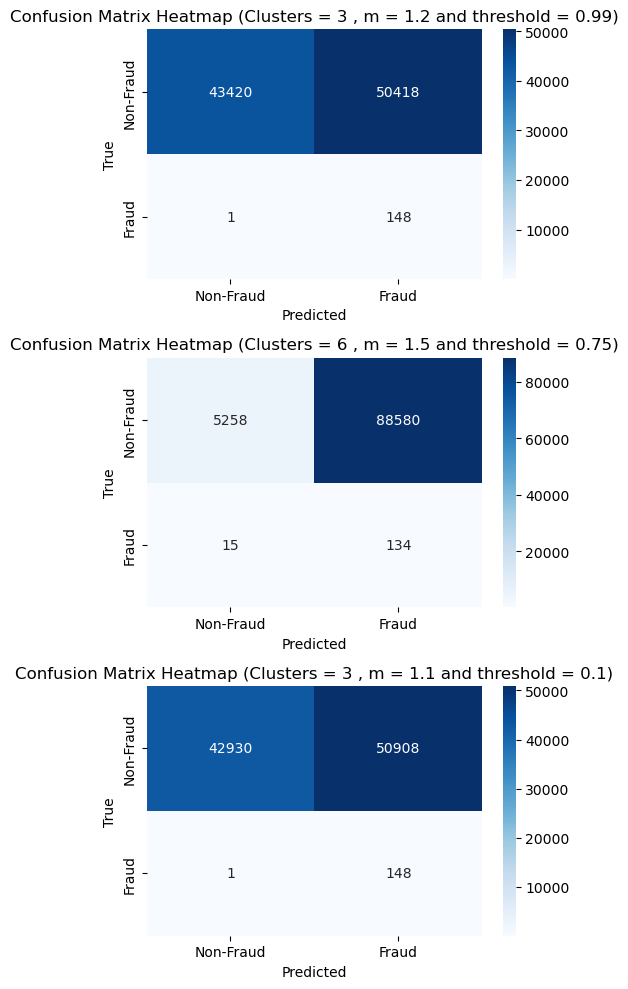

In [202]:
# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(3, 1, figsize=(5, 10))

sns.heatmap(confusion_fcm_3, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix Heatmap (Clusters = 3 , m = 1.2 and threshold = 0.99)')

sns.heatmap(confusion_fcm_2, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix Heatmap (Clusters = 6 , m = 1.5 and threshold = 0.75)')

sns.heatmap(confusion_fcm_1, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_title('Confusion Matrix Heatmap (Clusters = 3 , m = 1.1 and threshold = 0.1)')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

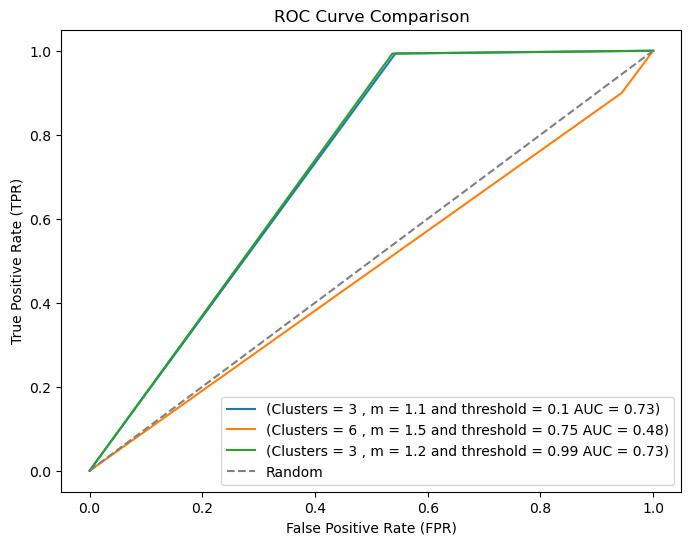

In [205]:
# Set 1
fpr_1, tpr_1, _ = roc_curve(y_test, binary_labels_test_fcm_1)
roc_auc_1 = auc(fpr_1, tpr_1)

# Set 2
fpr_2, tpr_2, _ = roc_curve(y_test, binary_labels_test_fcm_2)
roc_auc_2 = auc(fpr_2, tpr_2)

# Set 3
fpr_3, tpr_3, _ = roc_curve(y_test, binary_labels_test_fcm_3)
roc_auc_3 = auc(fpr_3, tpr_3)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, label=f'(Clusters = 3 , m = 1.1 and threshold = 0.1 AUC = {roc_auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'(Clusters = 6 , m = 1.5 and threshold = 0.75 AUC = {roc_auc_2:.2f})')
plt.plot(fpr_3, tpr_3, label=f'(Clusters = 3 , m = 1.2 and threshold = 0.99 AUC = {roc_auc_3:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()

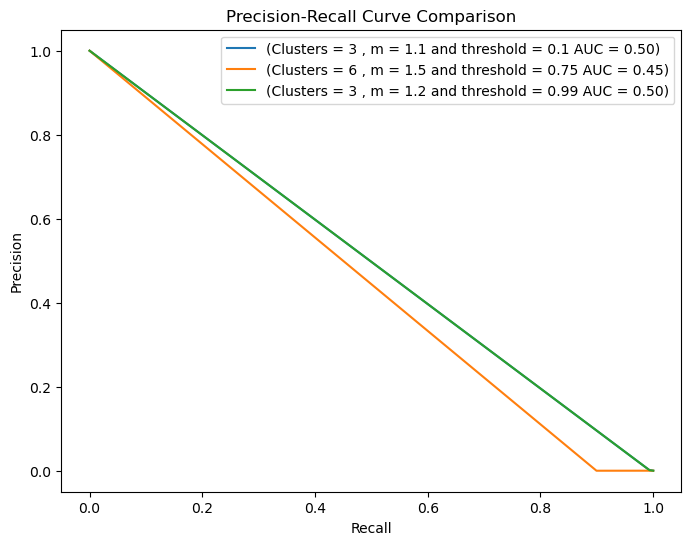

In [206]:
from sklearn.metrics import precision_recall_curve, auc

# Assuming you have precision and recall values for each set
precision_1, recall_1, _ = precision_recall_curve(y_test, binary_labels_test_fcm_1)
pr_auc_1 = auc(recall_1, precision_1)

precision_2, recall_2, _ = precision_recall_curve(y_test, binary_labels_test_fcm_2)
pr_auc_2 = auc(recall_2, precision_2)

precision_3, recall_3, _ = precision_recall_curve(y_test, binary_labels_test_fcm_3)
pr_auc_3 = auc(recall_3, precision_3)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_1, precision_1, label=f'(Clusters = 3 , m = 1.1 and threshold = 0.1 AUC = {pr_auc_1:.2f})')
plt.plot(recall_2, precision_2, label=f'(Clusters = 6 , m = 1.5 and threshold = 0.75 AUC = {pr_auc_2:.2f})')
plt.plot(recall_3, precision_3, label=f'(Clusters = 3 , m = 1.2 and threshold = 0.99 AUC = {pr_auc_3:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.show()

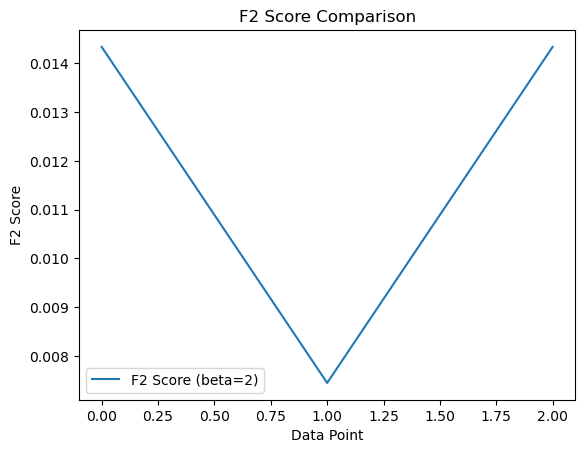

In [204]:
# Assuming you have lists of precision and recall values
precision_values = [0.0029, 0.0015, 0.0029]
recall_values = [0.9933, 0.8993, 0.9933]

# Define the beta parameter for F2 score
beta = 2

# Calculate F2 scores
f2_scores = [(1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) for precision, recall in zip(precision_values, recall_values)]

# Plot F2 scores
plt.plot(f2_scores, label=f'F2 Score (beta={beta})')
plt.plot(f2_scores, label=f'F2 Score (beta={beta})')
plt.plot(f2_scores, label=f'F2 Score (beta={beta})')
plt.xlabel('Data Point')
plt.ylabel('F2 Score')
plt.title('F2 Score Comparison')
plt.legend()
plt.show()